In [1]:
import pandas as pd
import numpy as np
import torch
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


# Weather

In [ ]:
import os
import glob
import pandas as pd
import torch

def load_or_preprocess(directory_path, cache_path, sum_threshold=50):
    """
    If cache_path exists, load and return the tensor.
    Otherwise, read all CSVs in directory_path, filter, convert to tensor, save at cache_path, then return.
    """
    # 1) If cache exists, just load it
    if os.path.exists(cache_path):
        print(f"🔄 Loading cached tensor from {cache_path}")
        return torch.load(cache_path)
    
    # 2) Otherwise, preprocess
    print(f"📦 Preprocessing CSVs in {directory_path} ...")
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    tensors = []
    
    for fp in csv_files:
        try:
            df = pd.read_csv(fp)
            
            # Drop datetime
            df = df.drop(columns='dt_UTC01_NoDLS', errors='ignore')
            
            # Numeric + drop NaNs
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
            
            # Sum filter
            df = df[df.sum(axis=1) >= sum_threshold]
            
            if not df.empty:
                # To float32 to save memory
                t = torch.tensor(df.values, dtype=torch.float32)
                # Optional: clamp negatives here: t = t.clamp(min=0.0)
                tensors.append(t)
        except Exception as e:
            print(f"  ⚠️ Skipping {fp}: {e}")
    
    if not tensors:
        raise RuntimeError(f"No data found in {directory_path} after filtering.")
    
    data = torch.cat(tensors, dim=0)
    # 3) Save to cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    torch.save(data, cache_path)
    print(f"✅ Preprocessed and saved to {cache_path}, shape = {data.shape}")
    return data

# Usage:
train_tensor = load_or_preprocess('dat/train', 'cached/train.pt', sum_threshold=200)
val_tensor   = load_or_preprocess('dat/val',   'cached/val.pt',   sum_threshold=200)
test_tensor  = load_or_preprocess('dat/test',  'cached/test.pt',  sum_threshold=200)


🔄 Loading cached tensor from cached/train.pt


/tmp/ipykernel_5669/2737937659.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)


🔄 Loading cached tensor from cached/val.pt
🔄 Loading cached tensor from cached/test.pt


In [3]:
# Process each dataset
train_tensor = load_dataset_from_dir('dat/train')


⚠️ File dat/train/tc_2020-07-25_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-05-01_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-12_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-09-03_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-22_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-02_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-30_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-04-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-13_full_day

In [4]:
val_tensor   = load_dataset_from_dir('dat/val')

⚠️ File dat/val/tc_2023-08-06_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2025-01-21_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-08-02_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-07-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2025-03-12_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-09-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-09-10_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-11-15_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-06-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-06-17_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2025-01-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-11-18_full_day.csv has no valid rows after filtering.
⚠️ File dat/val/tc_2023-06-15_full_day.csv has no valid rows aft

In [5]:
test_tensor  = load_dataset_from_dir('dat/test')

⚠️ File dat/test/tc_2024-05-19_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-04-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-04-15_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-04-13_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-05-22_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-09-15_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-04-14_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-09-13_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-07-24_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-09-14_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-05-18_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-09-12_full_day.csv has no valid rows after filtering.
⚠️ File dat/test/tc_2024-05-20_full_day.csv has no v

In [4]:
train_tensor = load_dataset_from_dir('dat/train', 'cached/train_tensor.pt')
val_tensor   = load_dataset_from_dir('dat/val',   'cached/val_tensor.pt')
test_tensor  = load_dataset_from_dir('dat/test',  'cached/test_tensor.pt')


📦 Processing raw CSV files in dat/train ...
⚠️ File dat/train/tc_2020-07-25_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-05-01_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-12_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-09-03_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-22_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-02_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-30_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-04-16_full_day.csv has no valid rows after filteri

KeyboardInterrupt: 

# do not run 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = train_tensor.to(device)
print(f"Tensor is on: {data_tensor.device}")

Tensor is on: cuda:0


In [4]:
print("Tensor shape:", data_tensor.shape)  # (N, 801), where N is the number of time stamps

Tensor shape: torch.Size([935847, 801])


In [5]:
# # Min-max normalization
min_vals = data_tensor.min(dim=0, keepdim=True).values
max_vals = data_tensor.max(dim=1, keepdim=True).values

# Avoid divide-by-zero by adding a small epsilon
normalized_tensor = (data_tensor) / (max_vals + 1e-8)

# normalized_tensor = data_tensor



# Wrap data into a TensorDataset and DataLoader
dataset = TensorDataset(normalized_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [6]:
max_vals.shape

torch.Size([935847, 1])

# RUN HERE

In [3]:
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),

            nn.Linear(1000, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),

            nn.Linear(1000, input_dim)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [4]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder (EXACT dimensions)
        self.enc_conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2)  # 801 → 401
        self.enc_bn1 = nn.BatchNorm1d(32)
        
        self.enc_conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)  # 401 → 201
        self.enc_bn2 = nn.BatchNorm1d(64)
        
        self.enc_conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)  # 201 → 101
        self.enc_bn3 = nn.BatchNorm1d(128)
        
        self.enc_conv4 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)  # 101 → 51
        self.enc_bn4 = nn.BatchNorm1d(256)
        
        # Bottleneck (6D)
        self.bottleneck_conv = nn.Conv1d(256, 6, kernel_size=5, stride=2, padding=2)  # 51 → 26
        self.bottleneck_fc = nn.Linear(26*6, 6)
        
        # Decoder (EXACT reverse with correct channel counts)
        self.dec_fc = nn.Linear(6, 26*6)
        self.dec_deconv1 = nn.ConvTranspose1d(6, 256, kernel_size=5, stride=2, padding=2, output_padding=1)  # 26 → 51
        
        # Skip connection layers (input channels = decoder channels + skip channels)
        self.dec_conv1 = nn.ConvTranspose1d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=1)  # 51 → 101
        self.dec_conv2 = nn.ConvTranspose1d(256, 64, kernel_size=5, stride=2, padding=2, output_padding=1)  # 101 → 201
        self.dec_conv3 = nn.ConvTranspose1d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1)  # 201 → 401
        self.dec_conv4 = nn.ConvTranspose1d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1)  # 401 → 801
        
        # Batch norms
        self.dec_bn1 = nn.BatchNorm1d(128)
        self.dec_bn2 = nn.BatchNorm1d(64)
        self.dec_bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1(x)))  # [B,32,401]
        x2 = F.relu(self.enc_bn2(self.enc_conv2(x1)))  # [B,64,201]
        x3 = F.relu(self.enc_bn3(self.enc_conv3(x2)))  # [B,128,101]
        x4 = F.relu(self.enc_bn4(self.enc_conv4(x3)))  # [B,256,51]
        
        # Bottleneck
        x5 = F.relu(self.bottleneck_conv(x4))  # [B,6,26]
        x5_flat = x5.view(x5.size(0), -1)  # [B,156]
        bottleneck = self.bottleneck_fc(x5_flat)  # [B,6]
        
        # Decoder
        z = F.relu(self.dec_fc(bottleneck)).view(-1,6,26)  # [B,6,26]
        z = F.relu(self.dec_deconv1(z))  # [B,256,51]
        
        # Skip connections
        z = torch.cat([z, x4], dim=1)  # [B,512,51]
        z = F.relu(self.dec_bn1(self.dec_conv1(z)))  # [B,128,101]
        
        z = torch.cat([z, x3], dim=1)  # [B,256,101]
        z = F.relu(self.dec_bn2(self.dec_conv2(z)))  # [B,64,201]
        
        z = torch.cat([z, x2], dim=1)  # [B,128,201]
        z = F.relu(self.dec_bn3(self.dec_conv3(z)))  # [B,32,401]
        
        z = torch.cat([z, x1], dim=1)  # [B,64,401]
        return self.dec_conv4(z), bottleneck  # [B,1,801], [B,6]

In [5]:
def evaluate_loss(model, data_tensor, batch_size=512):
    loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

    return total_loss / total_samples

# DO NOT TRAIN UNLESS NECCESSARY

Using device: cuda
Epoch 01/100 - Train Loss: 0.00610 | Val Loss: 0.00208
Epoch 02/100 - Train Loss: 0.00154 | Val Loss: 0.00115
Epoch 03/100 - Train Loss: 0.00128 | Val Loss: 0.00108
Epoch 04/100 - Train Loss: 0.00123 | Val Loss: 0.00107
Epoch 05/100 - Train Loss: 0.00112 | Val Loss: 0.00073
Epoch 06/100 - Train Loss: 0.00095 | Val Loss: 0.00100
Epoch 07/100 - Train Loss: 0.00088 | Val Loss: 0.00070
Epoch 08/100 - Train Loss: 0.00075 | Val Loss: 0.00072
Epoch 09/100 - Train Loss: 0.00071 | Val Loss: 0.00062
Epoch 10/100 - Train Loss: 0.00068 | Val Loss: 0.00060
Epoch 11/100 - Train Loss: 0.00078 | Val Loss: 0.00122
Epoch 12/100 - Train Loss: 0.00079 | Val Loss: 0.00055
Epoch 13/100 - Train Loss: 0.00064 | Val Loss: 0.00053
Epoch 14/100 - Train Loss: 0.00069 | Val Loss: 0.00055
Epoch 15/100 - Train Loss: 0.00059 | Val Loss: 0.00050
Epoch 16/100 - Train Loss: 0.00056 | Val Loss: 0.00055
Epoch 17/100 - Train Loss: 0.00056 | Val Loss: 0.00050
Epoch 18/100 - Train Loss: 0.00054 | Val Loss:

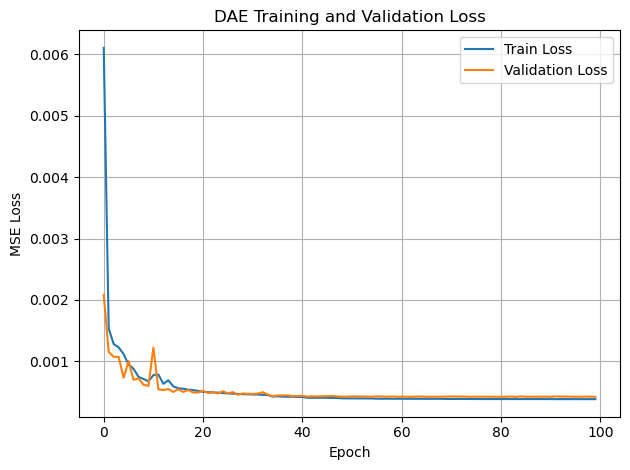

In [7]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Normalize
eps = 1e-8
# train_min = test_tensor.min(dim=1, keepdim=True).values
train_max = test_tensor.max(dim=1, keepdim=True).values
# train_tensor_norm = (test_tensor - train_min) / (train_max - train_min + eps)
train_tensor_norm = (test_tensor) / (train_max  + eps)

# val_min = val_tensor.min(dim=1, keepdim=True).values
val_max = val_tensor.max(dim=1, keepdim=True).values
# val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)
val_tensor_norm = (val_tensor) / (val_max + eps)

# Stay on CPU — no .to(device) here
train_dataset = TensorDataset(train_tensor_norm)
val_dataset = TensorDataset(val_tensor_norm)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Init model
input_dim = train_tensor.shape[1]
model = DAE(input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop
n_epochs = 100
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    avg_train_loss = total_train_loss / total_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_val_loss += loss.item() * x.size(0)
            val_samples += x.size(0)

    avg_val_loss = total_val_loss / val_samples


    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# Plot
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("DAE Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Device (SAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Normalize (SAME)
eps = 1e-8
# train_min = train_tensor.min(dim=1, keepdim=True).values
train_max = train_tensor.max(dim=1, keepdim=True).values
train_tensor_norm = (train_tensor - train_min) / (train_max - train_min + eps)

# val_min = val_tensor.min(dim=1, keepdim=True).values
val_max = val_tensor.max(dim=1, keepdim=True).values
val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)

# Datasets (SAME)
train_dataset = TensorDataset(train_tensor_norm)
val_dataset = TensorDataset(val_tensor_norm)

# DataLoaders (SAME)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Init model (ONLY CHANGE: ConvAE instead of DAE)
model = ConvAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# LR scheduler (NEW BUT OPTIONAL)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop (SAME STRUCTURE, MINOR ADJUSTMENTS)
n_epochs = 100
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        x = batch[0].to(device)
        x = x.unsqueeze(1)  # Add channel dim [batch, 1, 801] (ONLY NECESSARY CHANGE)
        
        optimizer.zero_grad()
        recon, _ = model(x)  # Unpack reconstruction
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    avg_train_loss = total_train_loss / total_samples

    # Validation (SAME STRUCTURE)
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            x = x.unsqueeze(1)  # Add channel dim [batch, 1, 801]
            recon, _ = model(x)  # Unpack reconstruction
            loss = criterion(recon, x)
            total_val_loss += loss.item() * x.size(0)
            val_samples += x.size(0)

    avg_val_loss = total_val_loss / val_samples
    
    # Update LR scheduler (NEW BUT OPTIONAL)
    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# Plot (SAME)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("ConvAE Training and Validation Loss")  # Only changed title
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cuda


NameError: name 'train_min' is not defined

# Code for ploting the original and the reconstructed spectrum

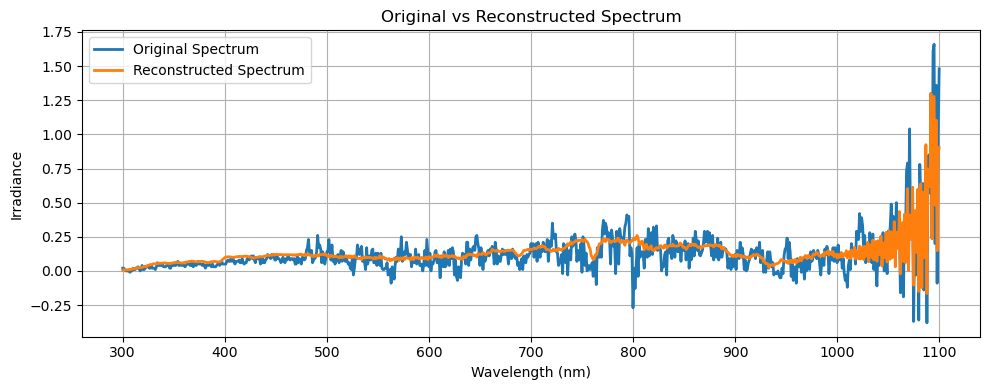

In [9]:
import matplotlib.pyplot as plt
import torch

# Select one example spectrum from the dataset (e.g., index 0)
idx = 0
original = test_tensor[idx]  # shape: (801,)
original = original.unsqueeze(0).to(device)  # shape: (1, 801)

# Run through DAE to get reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(original)

# Move both to CPU and convert to numpy
original_np = original.squeeze().cpu().numpy()
reconstructed_np = reconstructed.squeeze().cpu().numpy()

# X-axis: Wavelengths from 300 to 1100 nm
wavelengths = np.linspace(300, 1100, len(original_np))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(wavelengths, original_np, label='Original Spectrum', linewidth=2)
plt.plot(wavelengths, reconstructed_np, label='Reconstructed Spectrum', linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance')
plt.title('Original vs Reconstructed Spectrum')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Load the CSV
file_path = 'dat/test/tc_2024-01-01_full_day.csv'
df = pd.read_csv(file_path)

# Keep a copy of the datetime column
if 'dt_UTC01_NoDLS' in df.columns:
    time_column = df['dt_UTC01_NoDLS']
else:
    raise ValueError("dt_UTC01_NoDLS column not found.")

# Drop datetime for processing
df_numeric = df.drop(columns='dt_UTC01_NoDLS')

# Convert to numeric and clean
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()

# Find first row where sum > 25
row_sums = df_numeric.sum(axis=1)
first_valid_idx = row_sums[row_sums > 75].index[0]

# Get the datetime for that row
timestamp = time_column[first_valid_idx]

print("Timestamp of first valid row (sum > 25):", timestamp)


Timestamp of first valid row (sum > 25): 2024-01-01 08:14:00



# save the model

In [26]:
# Save the model (recommended PyTorch way)
torch.save(model.state_dict(), "convdae_model.pth")
print("Model saved to dae_model.pth")


Model saved to dae_model.pth


# load the model

In [20]:
device='cuda'
model = DAE(input_dim=801)
model.load_state_dict(torch.load("dae_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_5612/2109932598.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dae_model.pth", map_location=device))


DAE(
  (encoder): Sequential(
    (0): Linear(in_features=801, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=300, bias=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=300, bias=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_fea

In [21]:
model.eval()
device = 'cuda'
model.to(device)



# Move normalized input to device
with torch.no_grad():
    latent_representations = model.encoder(test_tensor.to(device))

# Move to CPU and convert to numpy if needed
latent_representations = latent_representations.cpu()

print("Latent shape:", latent_representations.shape)  # Should be (60, 6)
print("Device", latent_representations.device)

Latent shape: torch.Size([272439, 6])
Device cpu


In [22]:
from torch.utils.data import DataLoader, TensorDataset

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512  # adjust down if OOM again
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size)

all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())  # keep on CPU to save GPU mem

latent_representations = torch.cat(all_latents, dim=0)
print("Latent shape:", latent_representations.shape)


Latent shape: torch.Size([272439, 6])


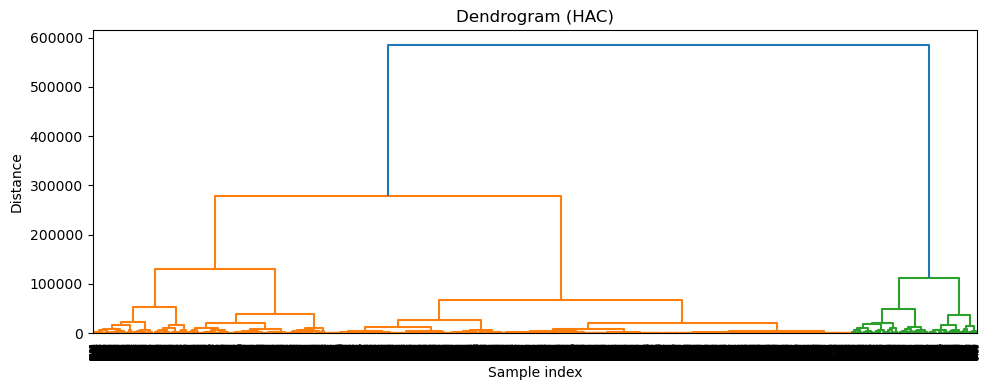

In [23]:


# Convert to numpy if not already
latent_np = latent_representations.numpy()

sampled_latent = latent_np[np.random.choice(latent_np.shape[0], size=10000, replace=False)]

# Optional: dendrogram visualization (just for fun)
linked = linkage(sampled_latent, method='ward')
plt.figure(figsize=(10, 4))
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           labels=np.arange(len(sampled_latent)))

plt.title("Dendrogram (HAC)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

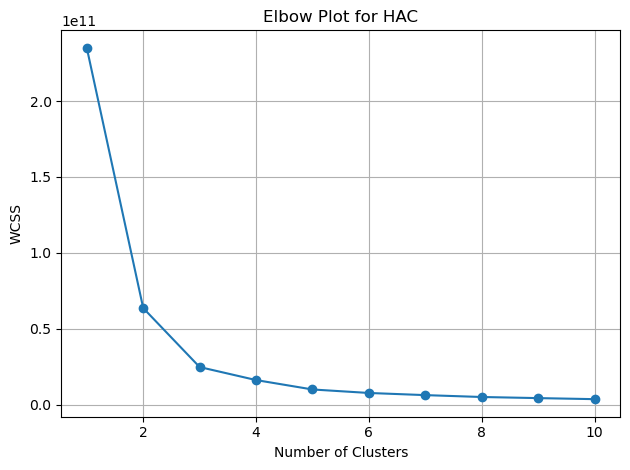

In [24]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(sampled_latent)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = sampled_latent[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:

# HAC with 5 clusters
hac_5 = AgglomerativeClustering(n_clusters=4)
cluster_labels = hac_5.fit_predict(sampled_latent)

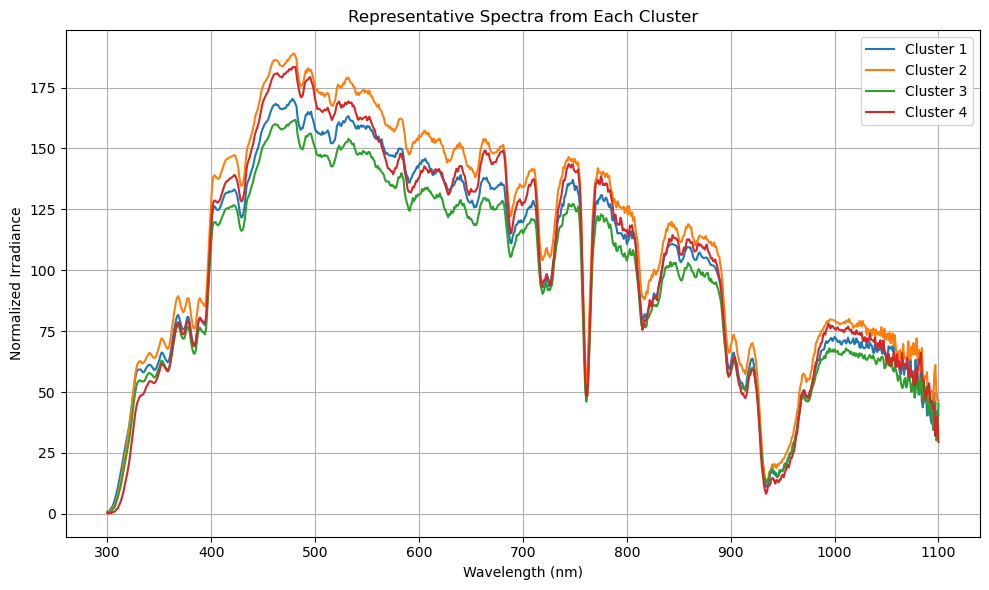

In [28]:

representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Step 1: Get indices of samples in this cluster
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = latent_np[cluster_idx]

    # Step 2: Compute pairwise distances within the cluster
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')

    # Step 3: Sum distances for each sample
    sum_dists = pairwise_dists.sum(axis=1)

    # Step 4: Select index with minimum total distance
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Step 5: Get the corresponding original spectra (denormalized if needed)
rep_spectra = test_tensor[representative_indices].cpu().numpy()

# Step 6: Plot the representative spectra
plt.figure(figsize=(10, 6))
#wavelengths = spectra['Wavelength'].values  # original x-axis
wavelengths = np.arange(300, 1101)

for i, spec in enumerate(rep_spectra):
    plt.plot(wavelengths, spec, label=f'Cluster {i+1}')

plt.title('Representative Spectra from Each Cluster')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

green one is red-shift, because it is lower on the left of the peak amd higher on high wavelength